In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')
from data.audio_dataset import AudioSpectrogramDataset
from models.WGAN_model.WPGAN import WPGAN
from models.WGAN_model.config import *

import torch
import librosa
import soundfile as sf
from torch.utils.data import DataLoader

C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# import torchvision.datasets as dset
# import torchvision.transforms as transforms

# image_size = 64
# # learning_rate = 0.0002
# learning_rate = 0.0001

# dataroot = "../data/raw/celeba2/"

# dataset = dset.ImageFolder(root=dataroot,
#                            transform=transforms.Compose([
#                                transforms.Resize(image_size),
#                                transforms.CenterCrop(image_size),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                            ]))

# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
#                                          shuffle=True, num_workers=2)

In [3]:
dataset = AudioSpectrogramDataset(base_directory=base_directory, spectro_type='mel')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
Music_WPGAN = WPGAN(
    latent_dim=latent_dim,
    output_dim=output_dim,
    lr=learning_rate,
    loss=loss,
    batch_size=batch_size,
    gpu=gpu,
    depths=depths, 
    negative_slope=negative_slope,
    fade_in_percentage=fade_in_percentage,
    save_interval=save_interval,
    normalization=normalization,
    mini_batch_normalization=mini_batch_normalization,
    init_resolution_size=init_resolution_size,
    num_epochs_per_resolution=num_epochs_per_resolution,
    gen_output_dim=gen_output_dim,
    c=c,
    n_critic=n_critic
)

In [5]:
Music_WPGAN.train(dataloader=dataloader)

Resolution 0 - Epoch 1/10 - D Loss: -0.0836309939622879 - G Loss: 0.06095467135310173
Resolution 0 - Epoch 2/10 - D Loss: -0.25586649775505066 - G Loss: 0.16215777397155762
Resolution 0 - Epoch 3/10 - D Loss: -0.3638426959514618 - G Loss: 0.2391357123851776
Resolution 0 - Epoch 4/10 - D Loss: -0.5158158540725708 - G Loss: 0.3379928767681122
Resolution 0 - Epoch 5/10 - D Loss: -0.5977906584739685 - G Loss: 0.40668991208076477
Resolution 0 - Epoch 6/10 - D Loss: -0.6217045783996582 - G Loss: 0.4806339144706726
Resolution 0 - Epoch 7/10 - D Loss: -0.39720088243484497 - G Loss: 0.4988618493080139
Resolution 0 - Epoch 8/10 - D Loss: -1.1064000129699707 - G Loss: 0.6745364665985107
Resolution 0 - Epoch 9/10 - D Loss: -1.1619783639907837 - G Loss: 0.7244914770126343
Resolution 0 - Epoch 10/10 - D Loss: -1.211156964302063 - G Loss: 0.7296359539031982
Resolution 1 - Epoch 1/10 - D Loss: -1.4988083839416504 - G Loss: 0.8651924133300781
Resolution 1 - Epoch 2/10 - D Loss: -1.5221166610717773 - G 

In [ ]:
checkpoint_path = "../src/models/WGAN_model/checkpoints/WPGAN_checkpoint_res1_epoch4.pth"
Music_WPGAN.train(dataloader=dataloader, checkpoint_path=checkpoint_path)

In [7]:
Music_WPGAN.close_all_writers()

In [9]:
Music_WPGAN.save_full_model("WPGAN")

Full model saved: c:\0. Studia\0. Praca inzynierska\Music_Samples_Generator\src\models\WGAN_model\../../../models/saved_models/WPGAN/WPGAN


In [8]:
Music_WPGAN.generator.eval()

PGenerator(
  (blocks): ModuleList(
    (0): ModuleList(
      (0): Sequential(
        (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
      (1): Sequential(
        (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
      (2): Sequential(
        (0): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): ModuleList(
      (0): Sequential(
        (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
      (1): Sequential(
        (0): ConvTranspos

In [9]:
z = torch.randn(1, Music_WPGAN.latent_dim).to(Music_WPGAN.device)
generated_spectrogram = Music_WPGAN.generator(z)

In [10]:
spectrogram = generated_spectrogram.cpu().detach().numpy()
spectrogram = spectrogram.squeeze()

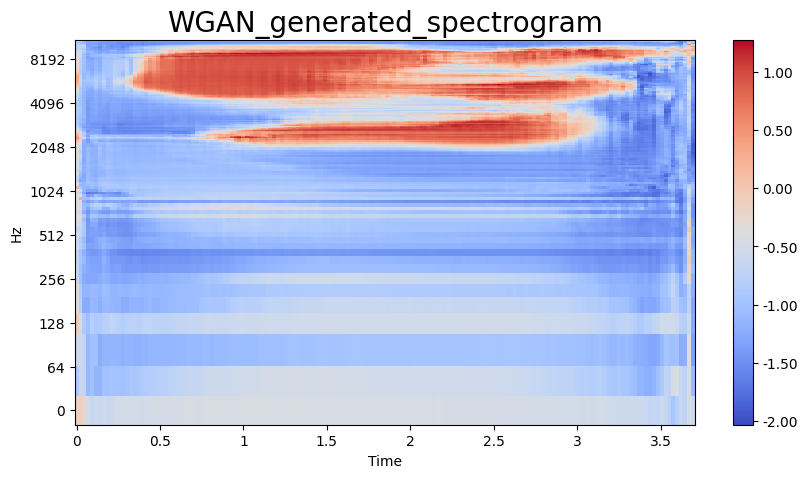

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

img = librosa.display.specshow(spectrogram, x_axis='time', y_axis='log')
plt.title('WGAN_generated_spectrogram', fontsize=20)
plt.colorbar(img, format='%0.2f')

plt.show()

In [15]:
audio = librosa.feature.inverse.mel_to_audio(spectrogram)

path = '../models/generated_samples/'
file_name = 'WPGAN_generated_audio.wav'

sf.write(path + file_name, audio, 22050)